# Introduction: IMDB Movies - Data analysis Project

This project focuses on the analysis of the 500 highest rated IMDB movies between 2000-2012. The movies have been examined in terms of different characteristics, such as gross revenue, popularity, etc. The project serves as a demonstration of web-scrapping via Beautiful Soup, as well as data exploratory analysis.

## Workflow followed

The process I followed has generally been:

    1.Data scrapping
    2.Data cleaning, reshaping, quality checks
    3.Exploratory Data Analysis (EDA)
    4.Final interactive visualization on Tableau Software
    
For the data extraction I have used the Beautiful Soup library. 

For data cleaning and manipulation I have made use of numpy/pandas, and the EDA phase involved use of matplotlib / seaborn.

Eventually, the final dataset has been exported to csv file and passed as a datasource to an **interactive Tableau Dashboard**, which provides different insights. You can give it a try in the following link:

* <a href="https://public.tableau.com/profile/charisispapacharisis#!/vizhome/500IMDBmovies-publishedversion/DirectorsIMDBratings" target="_blank">Deep-dive into the 500 best IMDB movies (2000 - 2012)</a>


## Imports
We start by importing the relevant libraries.

In [1]:
# Telling matplotlib to print 'inline' in this notebook
%matplotlib inline

# Importing the required libraries
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pandas as pd

# libraries to manage the crawling rate
from time import sleep
from time import time
from random import randint
from IPython.core.display import clear_output

# the 'get' function will request from the server the content of the web page
from requests import get

We identify the URL that contains our target content, and this is assigned to a variable below. 

For this project, I have decided to focus on an <a href="https://www.imdb.com/list/ls050871124/?sort=user_rating,desc&st_dt=&mode=detail&page=1&ref_=ttls_vm_dtl" target="_blank">IMDB list</a> with the 500 best 2000-2012 movies.

We request its content via the *'get'* function and parse it with the *Beautiful Soup*.

Note: Depending on the country, IMDB movie titles might be translated into the local language. In order to avoid this, we can use the *'Accept Language'* setting, which declares that our language of preference is American English (en-US) - and if this is not available, then we accept other English language versions (en).

In [2]:
# Picking the URL
url='https://www.imdb.com/list/ls050871124/?sort=user_rating,desc&st_dt=&mode=detail&page=1&ref_=ttls_vm_dtl'

# Communicating language preferences to the server.
headers = {"Accept-Language": "en-US, en;q=0.5"}

response = get(url, headers = headers)
imdb_soup = BeautifulSoup(response.text,'html.parser')

## Webpage HTML Structure

When visiting the IMDB page, we can examine the HTML code of a listed movie *(in Chrome: right click -> Inspect)*. This reveals the structure behind what we see in the page. 

The HTML of the webpage is built from various components, which are organized in **'div'** tags.

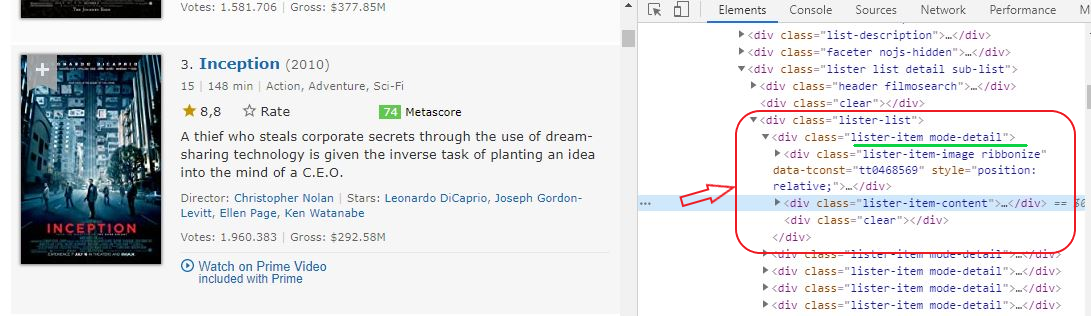

As we see in the printscreen, this involves a lot of div sections. What is important, is to locate the exact part of the page that contains the information we are interested in.

I am personally interested in the *Movie duration, IMDB score, name, year of release, name of director, gross revenue*. All this exists inside this grey box which contains also the movie thumbnail.

The next step is to identify what is the **differentiating factor** that will allow us to access that section. It appears that these movie 'boxes' are corresponding to 'div' tags characterized by the combination of the class attributes 'lister-item' and 'mode-detail'. So these will function as our primary key. 

We will use the 'find all' function to get all these sections from the page we are currently viewing.

In [3]:
imdb_containers = imdb_soup.find_all('div', class_='lister-item mode-detail')

# let's print the total of the containers identified
print(len(imdb_containers))

100


We see that this code identified 100 containers. This is in line with our expectations, as we expect this page to include 100 of the total 500 movies of this IMDB list. 

We will focus on writing the code for one page (100 containers), and then we will expand to all pages of the list.

As I expect to export 500 times the aforementioned details (movie names, years, ratings, etc) I will define 'storing lists' in order to populate them later on.

In [4]:
names = []
years = []
imdb_ratings = []
gross_amounts = []
votes = []
directors = []
URLs = []
durations = []

## Web Scrapping

For each of the containers, we will try to extract the relevant info. We see that the structure is made of tags which are nested inside others. Our goal is to identify the unique tag hierarchy that will lead us to the target data.

**Name:** The movie name is contained in an 'a' tag, which is nested inside a 'h3' tag, which is nested inside the 'div' tag of this movie. Hence, using attribute notation we can access the *text* attribute inside the first &lt;a>, inside the &lt;h3> : *container.h3.a.text*

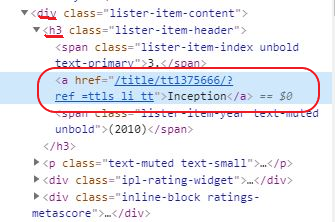

**Year**: Following the same idea of accessing in steps the nested tags, the movie year is inside the h3 tag, and specifically inside a 'span' tag - with lister-item-year AND text-muted unbold as class attributes. 

**IMDB rating**: A similar process followed, with the attribute: 'ipl-rating-star__rating'.

**Number of votes**: This is contained within a &lt;span> tag, followed by a 'name' attribute with 'nv' as value.

**Gross Revenue**: On the IMDB webpage, this feature is formatted as a string with thousand separators. We want to convert this into number, for any calculations. In order to do so, firstly I take out the commas with the replace function, and then convert to float, as shown in the code below.

**URLs**: I would like to also store the URL address of each particular movie of this list, in order to be able to be access them later. Moreover, I plan to use them as part of the Tableau visualization dashboard at the end of the project. For this, I locate the tag containing the URL suffix, extract it, and then concatenate it with the '`https://www.imdb.com`' string, in order to form the full URL.

Similarly, we focus on finding unique paths and identifiers, *for all pieces of information*. The code follows below.

We iterate across all 100 containers of this page and append the findings to the aforementioned storing lists.

In [5]:
for container in imdb_containers: # looping through all containers of this page
    
    # this 'attributes' variable keeps all 'span' tag occurencies in this container with 'name'/'nv' as attribute/value
    attributes = container.find_all('span', attrs = {'name':'nv'}) 
       
    if len(attributes) == 2:
        
    # The name
        name = container.h3.a.text
        names.append(name)
        
    # The year
        year = container.h3.find('span',class_ = 'lister-item-year text-muted unbold').text
        years.append(year)
        
    # The IMDB rating
        imdb = float(container.find('span',class_ = 'ipl-rating-star__rating').text) # extracting the rating and coverting to float
        imdb_ratings.append(imdb)

    # The number of votes
        voters_temp = attributes[0]  # accessing the right 'span' tag to get to the number of votes
        voters = int(voters_temp['data-value']) # extracting the votes and coverting to integer
        votes.append(voters)
      
    # The Gross
        gross_temp = attributes[1]  # accessing the right 'span' tag to get to the gross revenue
        gross_value = (gross_temp['data-value'])
        gross_value_without_symbol = gross_value[0:].replace(',', '') 
        gross =(float(gross_value_without_symbol)) # converting the string to float
        gross_amounts.append(gross)
        
    # The directors
        ptags =(container.find_all('p',class_ = 'text-muted text-small',))
        director = ptags[1].a.text
        directors.append(director)
        
    # The URLs
        URL_temp = container.h3.a['href']
        URL_prefix = 'https://www.imdb.com'
        URL = URL_prefix + URL_temp
        URLs.append(URL)
        
    # The durations
        duration_temp = container.find('span',class_ = 'runtime').text
        duration_temp = duration_temp.split()
        duration = int(duration_temp[0])
        durations.append(duration)           


After scrapping all this information, we will organize it in a dataframe using the pandas library. We define below the column names and assign the previous lists to each of them.

We basically create a dataframe using a *dictionary of lists*. In this dictionary, each key becomes the column name in the data frame and each value (list) becomes column rows. We take a look at the head of it.

In [6]:
df = pd.DataFrame({'Name':names, 'Year':years, 'IMDB rating':imdb_ratings, 'Votes':votes, 'Gross':gross_amounts, 'Directors':directors, 'URLs':URLs, 'Durations':durations})

df.head()

,Name,Year,IMDB rating,Votes,Gross,Directors,URLs,Durations
0,The Dark Knight,(2008),9.0,2207191,534858444.0,Christopher Nolan,https://www.imdb.com/title/tt0468569/,152
1,The Lord of the Rings: The Return of the King,(2003),8.9,1581991,377845905.0,Peter Jackson,https://www.imdb.com/title/tt0167260/,201
2,Inception,(2010),8.8,1960833,292576195.0,Christopher Nolan,https://www.imdb.com/title/tt1375666/,148
3,The Lord of the Rings: The Fellowship of the Ring,(2001),8.8,1595184,315544750.0,Peter Jackson,https://www.imdb.com/title/tt0120737/,178
4,The Lord of the Rings: The Two Towers,(2002),8.7,1429111,342551365.0,Peter Jackson,https://www.imdb.com/title/tt0167261/,179


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 8 columns):
Name           99 non-null object
Year           99 non-null object
IMDB rating    99 non-null float64
Votes          99 non-null int64
Gross          99 non-null float64
Directors      99 non-null object
URLs           99 non-null object
Durations      99 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.3+ KB


We see all columns to be full with non-null objects/numbers, an expected behaviour so far. Now it is time to expand the code for accessing all 5 pages of this list.


## Accessing multiple pages

We will use the same code as above, but *'nest'* them inside another *For* loop - for the 5 pages.

In every loop there is basically a different URL being accessed, so we need to define that address **dynamically**. Navigating through the 5 pages in our browser, we see that the URL structure remains the same, apart from a number (1-5) which changes according to the pages we are viewing at a time. Hence, in every iteration we construct the URL based on that, concatenating strings.

An additional point here is the need to control the crawl rate: as we will send several requests to the server for this operation, it is worth pausing it for a few seconds each time (sleep function). This will also protect the website from being ovlerloaded.

In [8]:
names = []
years = []
imdb_ratings = []
gross_amounts = []
votes = []
directors = []
URLs = []
durations = []

headers = {"Accept-Language": "en-US, en;q=0.5"}

starting_timestamp = time() # set the starting time
requests = 0  # counter of the requests to the server

for page in range(1,6):
    
    url='https://www.imdb.com/list/ls050871124/?sort=user_rating,desc&st_dt=&mode=detail&page=' + str(page) + '&ref_=ttls_vm_dtl'  
 
    response = get(url, headers = headers)
    
# Pause the loop for a randop number of seconds
    sleep(randint(8,15))
    
# Monitor the requests number and frequency
    requests += 1
    elapsed_time = time() - starting_timestamp
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)     
    
# Parse the content of the request with BeautifulSoup    
    imdb_soup = BeautifulSoup(response.text,'html.parser')
    imdb_containers = imdb_soup.find_all('div', class_='lister-item mode-detail')
    
    # iterate through the containers of this specific page
    for container in imdb_containers:

        attributes = container.find_all('span', attrs = {'name':'nv'})

        if len(attributes) == 2:
        # The name
            name = container.h3.a.text
            names.append(name)
            
        # The year
            year = container.h3.find('span',class_ = 'lister-item-year text-muted unbold').text
            years.append(year)
            
        # The IMDB rating
            imdb = float(container.find('span',class_ = 'ipl-rating-star__rating').text)
            imdb_ratings.append(imdb)

        # The number of votes
            voters_temp = attributes[0]
            voters = int(voters_temp['data-value'])
            votes.append(voters)
            
        # The Gross
            gross_temp = attributes[1]
            gross_value = (gross_temp['data-value'])
            gross_value_without_symbol = gross_value[0:].replace(',', '')
            gross =(float(gross_value_without_symbol))
            gross_amounts.append(gross)

        # The directors
            ptags =(container.find_all('p',class_ = 'text-muted text-small',))
            director = ptags[1].a.text
            directors.append(director)
            
        # The URLs
            URL_temp = container.h3.a['href']
            URL_prefix = 'https://www.imdb.com'
            URL = URL_prefix + URL_temp
            URLs.append(URL)
            
        # The durations
            duration_temp = container.find('span',class_ = 'runtime').text
            duration_temp = duration_temp.split()
            duration = int(duration_temp[0])
            durations.append(duration)         



Request:5; Frequency: 0.059869931053737245 requests/s


## Data Cleaning

Firstly, let's loop via all movies, for a quick quality check. 

We will wait 0.5sec for each movie to appear and then we will clear the output, for a better presentation.

In [9]:
for i in range(len(names)): 
    print (i, names[i]) 
    sleep(0.5)
    clear_output(wait = True)     

493 The Loneliest Planet


After extracting everything, we will organize it again in the dataframe, as before:

In [10]:
df = pd.DataFrame({'Name':names, 'Year':years, 'IMDB rating':imdb_ratings, 'Votes':votes, 'Gross':gross_amounts, 'Directors':directors, 'URLs':URLs, 'Durations':durations})

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 8 columns):
Name           494 non-null object
Year           494 non-null object
IMDB rating    494 non-null float64
Votes          494 non-null int64
Gross          494 non-null float64
Directors      494 non-null object
URLs           494 non-null object
Durations      494 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 31.0+ KB


There are not null data, which means there is no need to impute any values. Starting with the data cleaning, let's print all different years in the dataframe. We expect years between 2000 and 2012, as per the IMDB list name.

In [13]:
df['Year'].unique()

array(['(2008)', '(2003)', '(2010)', '(2001)', '(2002)', '(2006)',
       '(2012)', '(2000)', '(2009)', '(2004)', '(2011)', '(2005)',
       '(2007)', '(I) (2004)', '(I) (2011)', '(I) (2010)', '(I) (2007)',
       '(I) (2005)', '(I) (2006)', '(I) (2008)', '(I) (2009)',
       '(I) (2012)', '(II) (2009)', '(I) (2001)'], dtype=object)

We see that some years involve (I) or (II), and we would like to avoid that.

Checking df.info() above, we also see that the Year column is identified as object (string). We would like to convert that to integer. 

We can fix these two items with the below code:

In [14]:
df['Year'] = df['Year'].str[-5:-1].astype(int)
df['Year'].unique()

array([2008, 2003, 2010, 2001, 2002, 2006, 2012, 2000, 2009, 2004, 2011,
       2005, 2007], dtype=int64)

At this stage, I will extract the dataframe in csv format, in order to pass it on to Tableau Software, as source for a detailed visualization dashboard.

In [15]:
df.to_csv('IMBD_ratings.csv')

## Exploratory Data Analysis

We can now proceed with some EDA, leveraging on python viz libraries. 

Firstly, it would be interesting to see how the 500 movies of our list have been rated (IMDB scale: 0-10). We will choose an histogram for that, 'binning' our movies in clusters for better visibility (we choose 50 bins).

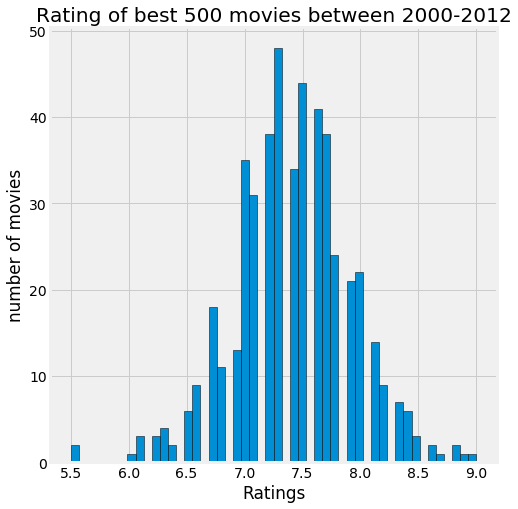

In [16]:
plt.figure(figsize=(8,8))

# Histogram of IMDB ratings

plt.style.use('fivethirtyeight')
plt.hist(df['IMDB rating'], bins = 50, edgecolor = 'k');
plt.xlabel('Ratings'); plt.ylabel('number of movies'); 
plt.title('Rating of best 500 movies between 2000-2012');

We observe a Gaussian distribution, with the majority of the movies concentrated between 6.8 and 8.2.

Next, let's check the distribution of gross revenue of the movies.

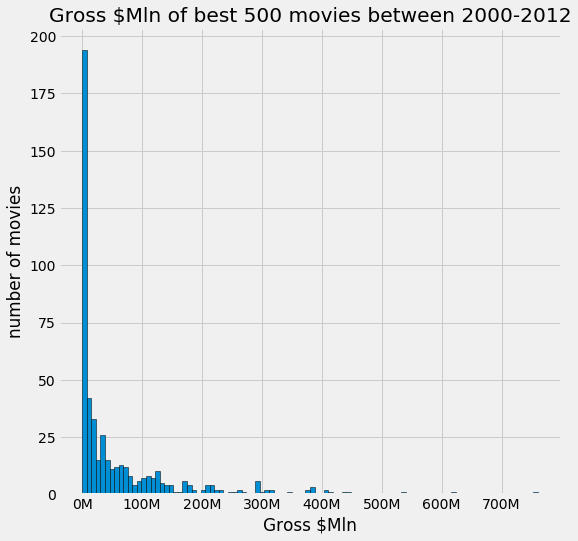

In [17]:
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

# Histogram of Gross Revenue
plt.figure(figsize = (8,8))
plt.style.use('fivethirtyeight')
plt.hist(df['Gross'], bins = 100, edgecolor = 'k');
plt.xlabel('Gross $Mln'); plt.ylabel('number of movies'); 
plt.title('Gross $Mln of best 500 movies between 2000-2012');

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

It is clear from this graph that the large majority of the movies have not generated more than $ 100 million. There are of course a few outliers ('blockbusters').

Moving on, we would like to identify if there is any correlation between the IMDB ratings and other features. For example, number of votes. We can use the *jointplot* of seaborn library:

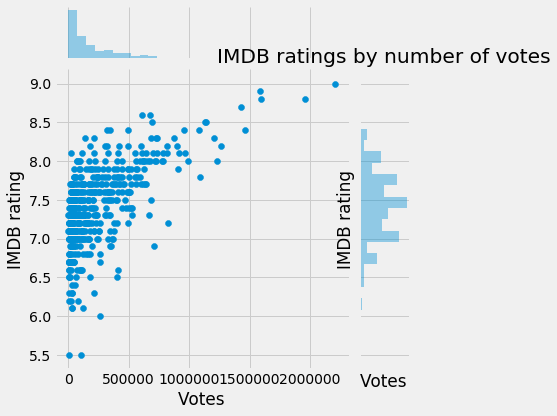

In [18]:
sns.jointplot(x='Votes', y='IMDB rating', data=df)
    
# label the plot
plt.xlabel('Votes'); plt.ylabel('IMDB rating'); 
plt.title('IMDB ratings by number of votes');

We can actually use the *pairplot* function to check  correlations across **any pair of features**, and identify trends:

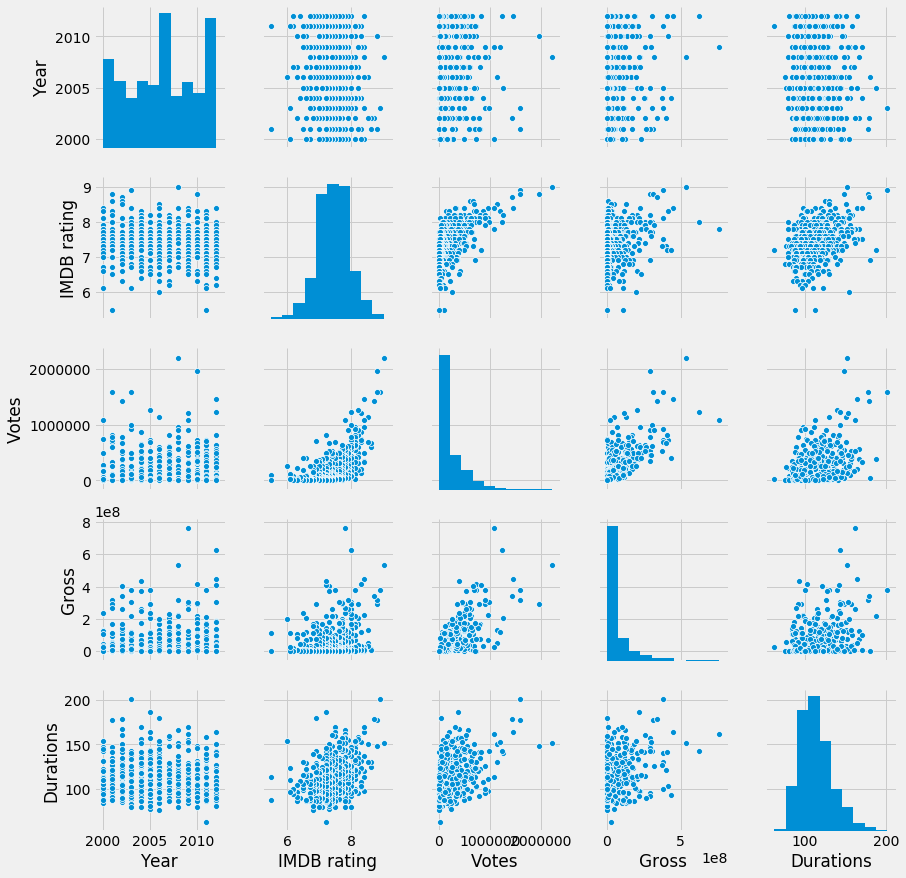

In [19]:
sns.pairplot(df);

From the above,  a few observations:

* We have slightly more votes for movies with shorter durations - which means that people could be more inclined to watch (and review) shorter movies rather than longer ones.


* In terms of duration, we observe a higher distribution of movies lasting around 120 minutes.


* The large majority of this popular list of movies have been reviewed a few 10,000s times. However, we see that movies that have been reviewed really a lot (more than 1 million votes) are the ones with the highest IMDB rating. We almost see a linear correlation between the rating of these positive outliers and their number of votes.

Lastly, let's check mathematically if there are high correlations between the IMDB rating and any of the other variables:


In [20]:
#Find all correlations and sort 
correlations_df = df.corr()['IMDB rating'].sort_values()

print(correlations_df)

Year          -0.103859
Gross          0.270852
Durations      0.383285
Votes          0.612960
IMDB rating    1.000000
Name: IMDB rating, dtype: float64


From the above, we don't see any particularly high correlation for any variable.

Vvalues closer to 1 would signify a higher correlation with the IMDB rating (and that is why 'IMDB rating' is showing up with 1, having a perfect correlation with itself).

## Interactive visualization on Tableau

As  mentioned, for further analysis and data insights, I have prepared a detailed dashboard in Tableau, which you can access in the below link:

<a href="https://public.tableau.com/profile/charisispapacharisis#!/vizhome/500IMDBmovies-publishedversion/DirectorsIMDBratings" target="_blank">Deep-dive into the 500  best IMDB movies (2000 - 2012)</a>